In [60]:
%%capture
!pip install pandas nltk scipy matplotlib openpyxl

In [61]:
suffix: str = "mistral_7b"

In [62]:
single_call_path: str = f"../resources/{suffix}/sampled_reviews_with_output_{suffix}.csv"
multi_call_path: str = f"../resources/{suffix}/sampled_reviews_with_output_multicall_{suffix}.csv"

In [63]:
import pandas as pd
import re
import json

single_call_dataframe: pd.DataFrame = pd.read_csv(single_call_path)
multi_call_dataframe: pd.DataFrame = pd.read_csv(multi_call_path)

In [64]:
single_call_dataframe.head(5)

,Unnamed: 0,review,sentiment,entities,json,progressive_index,output
0,434,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435,"```json\n{\n ""sentiment"": ""negative"",\n ""rev..."
1,3278,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279,"```json\n{\n ""sentiment"": ""neutral"",\n ""revi..."
2,967,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968,"```json\n{\n ""sentiment"": ""negative"",\n ""rev..."
3,1982,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983,"```json\n{\n ""sentiment"": ""negative"",\n ""rev..."
4,2902,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903,"```json\n{\n ""sentiment"": ""positive"",\n ""rev..."


In [65]:
multi_call_dataframe.head(5)

,Unnamed: 0,review,sentiment,entities,json,progressive_index,output
0,434,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435,"```json\n{\n ""sentiment"": ""neutral"",\n ""revi..."
1,3278,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279,"```json\n{\n ""sentiment"": ""This review doesn'..."
2,967,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968,"```json\n{\n ""sentiment"": ""review sentiment"",..."
3,1982,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983,"{\n ""sentiment"": ""negative"",\n ""review"": ""A ..."
4,2902,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903,"```json\n{\n ""sentiment"": ""positive"",\n ""rev..."


In [66]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smoothing_function: SmoothingFunction = SmoothingFunction()

ZERO_SCORE = ({
                  "review_score": .0,
                  "sentiment_score": .0,
                  "ner_score": {
                      "accuracy": .0,
                      "precision": .0,
                      "recall": .0,
                      "f1": .0
                  }
              }, .0)


def compute_bleu(reference: str, hypothesis: str) -> float:
    """
    It computes the BLEU score between hypothesis and reference.

    Arguments:
        hypothesis (list[str]): The hypothesis.
        reference (list[list[str]]): The reference.

    Return:
        The BLEU score.
    """
    return corpus_bleu([[reference.split()]], [hypothesis.split()], smoothing_function=smoothing_function.method1)


def evaluate(row: pd.DataFrame) -> (dict, float):
    try:
        ground_truth: dict = json.loads(row["json"])
    except Exception as e:
        print(str(e))
        return ZERO_SCORE, 0.0
    output: str = row["output"]
    groups = re.findall(pattern=r"(\{.*})", flags=re.DOTALL, string=output)
    if len(groups) != 1:
        return ZERO_SCORE

    group: str = groups[0]
    try:
        output_dict: dict = json.loads(group)
    except json.JSONDecodeError as e:
        print(str(e))
        return ZERO_SCORE

    review_score: float = compute_bleu(ground_truth["review"], output_dict["review"]) if "review" in output_dict else .0
    sentiment_score: float = 1.0 if "sentiment" in output_dict and output_dict["sentiment"] == ground_truth[
        "sentiment"] else 0.0

    ground_truth_entities: list[str] = ground_truth["entities"]
    score: dict = {
        "review_score": review_score,
        "sentiment_score": sentiment_score,
        "ner_score": {
            "accuracy": .0,
            "precision": .0,
            "recall": .0,
            "f1": .0
        }
    }
    if "entities" not in output_dict:
        return score, sum([review_score, sentiment_score, .0]) / 3.0

    detected_entities = output_dict["entities"] if "entities" in output_dict else []
    if len(detected_entities) == 0 and len(ground_truth_entities) == 0:
        score["ner_score"]["accuracy"] = 1.0
        score["ner_score"]["precision"] = 1.0
        score["ner_score"]["recall"] = 1.0
        score["ner_score"]["f1"] = 1.0
        return score, sum([review_score, sentiment_score, 1.0]) / 3.0

    false_negatives: int = 0  # Quelli che ci sono in GT, ma non nei detected
    false_positives: int = 0  # Quelli che sono stati individuati, ma non ci sono in GT
    true_positives: int = 0  # Quelli che sono stati correttamente individuati

    for ge in ground_truth_entities:
        ge_found: bool = False
        for de in detected_entities:
            if "label" not in de or "value" not in de or len(de.items()) != 2:
                continue
            label: str = de["label"]
            value: str = de["value"]
            if label == ge["label"] and value == ge["value"]:
                ge_found = True
                break
        if ge_found:
            true_positives += 1
        else:
            false_negatives += 1

    for de in detected_entities:
        if "label" not in de or "value" not in de or len(de.items()) != 2:
            false_positives += 1
            continue
        label: str = de["label"]
        value: str = de["value"]
        ge_found: bool = False
        for ge in ground_truth_entities:
            if label == ge["label"] and value == ge["value"]:
                ge_found = True
                break
        if not ge_found:
            false_positives += 1

    score["ner_score"]["accuracy"]: float = true_positives / (
            true_positives + false_positives) if true_positives + false_positives > 0 else .0
    score["ner_score"]["precision"]: float = true_positives / (
            true_positives + false_positives) if true_positives + false_positives > 0 else .0
    score["ner_score"]["recall"]: float = true_positives / (
                true_positives + false_negatives) if true_positives + false_negatives > 0 else .0
    score["ner_score"]["f1"] = 2 * (score["ner_score"]["precision"] * score["ner_score"]["recall"]) / (
                score["ner_score"]["precision"] + score["ner_score"]["recall"]) if (score["ner_score"]["precision"] +
                                                                                    score["ner_score"][
                                                                                        "recall"]) > 0 else .0

    return score, sum([review_score, sentiment_score, score["ner_score"]["f1"]]) / 3.0


In [67]:
def set_score(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe["score"] = dataframe.apply(
        lambda row: evaluate(row)[1], axis=1)
    dataframe["score_detail"] = dataframe.apply(
        lambda row: evaluate(row)[0], axis=1)
    dataframe["review_score"] = dataframe.apply(
        lambda row: row["score_detail"]["review_score"] if "review_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["sentiment_score"] = dataframe.apply(
        lambda row: row["score_detail"]["sentiment_score"] if "sentiment_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["ner_accuracy"] = dataframe.apply(
        lambda row: row["score_detail"]["ner_score"]["accuracy"] if "ner_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["ner_precision"] = dataframe.apply(
        lambda row: row["score_detail"]["ner_score"]["precision"] if "ner_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["ner_recall"] = dataframe.apply(
        lambda row: row["score_detail"]["ner_score"]["recall"] if "ner_score" in row["score_detail"] else 0.0, axis=1
    )
    dataframe["ner_f1"] = dataframe.apply(
        lambda row: row["score_detail"]["ner_score"]["f1"] if "ner_score" in row["score_detail"] else 0.0, axis=1
    )
    if "level_0" in dataframe.columns:
        dataframe.drop(columns=["level_0"], inplace=True)
    if "index" in dataframe.columns:
        dataframe.drop(columns=["index"], inplace=True)
    dataframe.reset_index(inplace=True)
    return dataframe

In [68]:
%%capture
multi_call_dataframe: pd.DataFrame = set_score(multi_call_dataframe)
single_call_dataframe: pd.DataFrame = set_score(single_call_dataframe)

In [69]:
multi_call_dataframe.head(5)

,index,Unnamed: 0,review,sentiment,entities,json,progressive_index,output,score,score_detail,review_score,sentiment_score,ner_accuracy,ner_precision,ner_recall,ner_f1
0,0,434,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435,"```json\n{\n ""sentiment"": ""neutral"",\n ""revi...",0.046715,"{'review_score': 0.14014609405201423, 'sentime...",0.140146,0.0,0.0,0.0,0.00,0.0
1,1,3278,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279,"```json\n{\n ""sentiment"": ""This review doesn'...",0.276869,"{'review_score': 0.8306070191829399, 'sentimen...",0.830607,0.0,0.0,0.0,0.00,0.0
2,2,967,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968,"```json\n{\n ""sentiment"": ""review sentiment"",...",0.482116,"{'review_score': 0.8463483376470088, 'sentimen...",0.846348,0.0,0.5,0.5,0.75,0.6
3,3,1982,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983,"{\n ""sentiment"": ""negative"",\n ""review"": ""A ...",0.666667,"{'review_score': 1.0, 'sentiment_score': 1.0, ...",1.000000,1.0,0.0,0.0,0.00,0.0
4,4,2902,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...",0.666667,"{'review_score': 1.0, 'sentiment_score': 1.0, ...",1.000000,1.0,0.0,0.0,0.00,0.0


In [70]:
single_call_dataframe.head(5)

,index,Unnamed: 0,review,sentiment,entities,json,progressive_index,output,score,score_detail,review_score,sentiment_score,ner_accuracy,ner_precision,ner_recall,ner_f1
0,0,434,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...",0.333358,"{'review_score': 7.254888118852912e-05, 'senti...",0.000073,1.0,0.0,0.0,0.00,0.000000
1,1,3278,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279,"```json\n{\n ""sentiment"": ""neutral"",\n ""revi...",0.276869,"{'review_score': 0.8306070191829399, 'sentimen...",0.830607,0.0,0.0,0.0,0.00,0.000000
2,2,967,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...",0.810812,"{'review_score': 0.765770758159472, 'sentiment...",0.765771,1.0,0.6,0.6,0.75,0.666667
3,3,1982,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983,"```json\n{\n ""sentiment"": ""negative"",\n ""rev...",0.526456,"{'review_score': 0.5793684007212752, 'sentimen...",0.579368,1.0,0.0,0.0,0.00,0.000000
4,4,2902,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903,"```json\n{\n ""sentiment"": ""positive"",\n ""rev...",0.368621,"{'review_score': 0.10586251711232521, 'sentime...",0.105863,1.0,0.0,0.0,0.00,0.000000


In [71]:
single_call_dataframe.to_excel(single_call_path.replace(".csv", ".xlsx"), index=False)
multi_call_dataframe.to_excel(multi_call_path.replace(".csv", ".xlsx"), index=False)

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def plot_score(score_key: str, single_call_dataframe: pd.DataFrame, multi_call_dataframe: pd.DataFrame):
    
    # Calculate descriptive statistics
    mean1, median1, std1 = single_call_dataframe[score_key].mean(), single_call_dataframe[score_key].median(), single_call_dataframe[score_key].std()
    mean2, median2, std2 = multi_call_dataframe[score_key].mean(), multi_call_dataframe[score_key].median(), multi_call_dataframe[score_key].std()

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot KDE for both datasets
    single_call_dataframe[score_key].plot(kind='kde', ax=ax[0], label='Single-Call', color='red')
    multi_call_dataframe[score_key].plot(kind='kde', ax=ax[0], label='Multi-Call', color='blue')
    
    # Set x and y limits
    ax[0].set_xlim(left=0.0, right=1.0)
    ax[0].set_ylim(bottom=0.0)
    
    # Add labels and title for the KDE plot
    capitalized = score_key.replace("_", " ").capitalize()
    ax[0].set_xlabel(capitalized)
    ax[0].set_ylabel('Density')
    ax[0].set_title('Density Plot Comparison')
    ax[0].grid(True)
    ax[0].legend()
    
    # Plot histograms for both datasets, side by side
    bin_width = 0.05
    bins = np.arange(0, 1 + bin_width, bin_width)
    
    # Plot histogram for Dataset 1
    ax[1].hist(single_call_dataframe[score_key], bins=bins, alpha=0.5, label='Single-Call', color='red', rwidth=0.9)
    
    # Plot histogram for Dataset 2
    ax[1].hist(multi_call_dataframe[score_key], bins=bins, alpha=0.5, label='Multi-Call', color='blue', rwidth=0.9)
    
    # Add descriptive statistics annotations
    ax[1].annotate(f'Mean: {mean1:.2f}\nMedian: {median1:.2f}\nStd Dev: {std1:.2f}',
                   xy=(0.75, 100), color='red', fontsize=10, weight='bold')
    ax[1].annotate(f'Mean: {mean2:.2f}\nMedian: {median2:.2f}\nStd Dev: {std2:.2f}',
                   xy=(0.75, 200), color='blue', fontsize=10, weight='bold')
    
    # Set limits, labels, and title for the histogram
    ax[1].set_xlim(left=0.0, right=1.0)
    ax[1].set_ylim(bottom=0.0)
    ax[1].set_xlabel(capitalized)
    ax[1].set_ylabel('Frequency')
    ax[1].set_title('Histogram Comparison')
    ax[1].grid(True)
    ax[1].legend()
    
    # Show the plot
    plt.tight_layout()
    plt.savefig(f"../resources/{suffix}/{suffix} - {capitalized} - evaluation.png", format='png', dpi=300)
    plt.show()

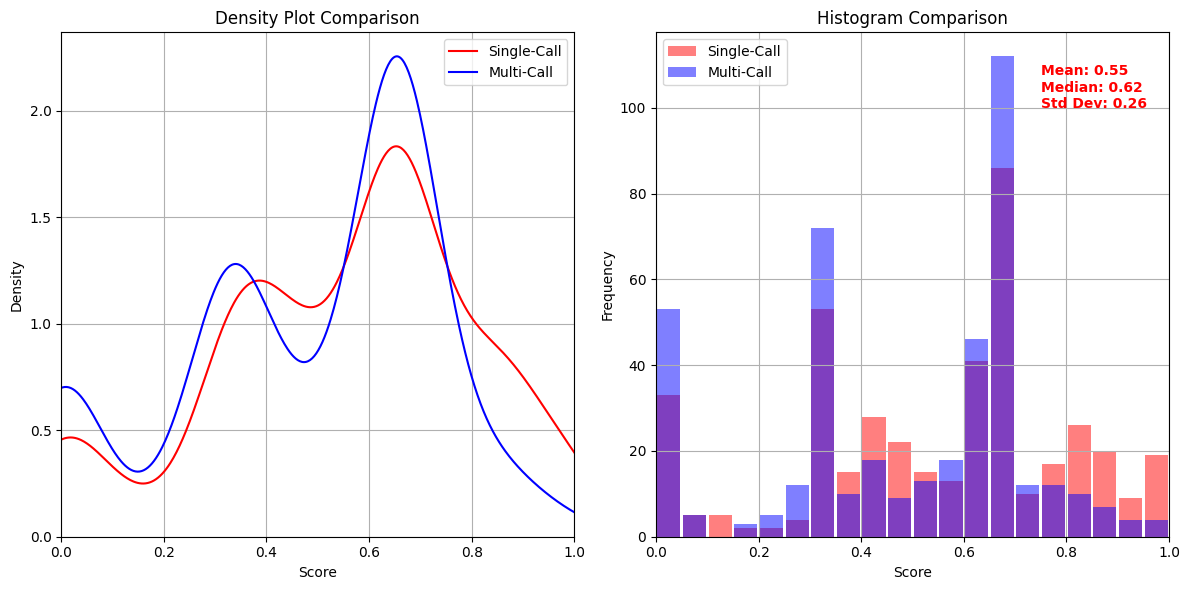

In [73]:
plot_score("score", single_call_dataframe, multi_call_dataframe)

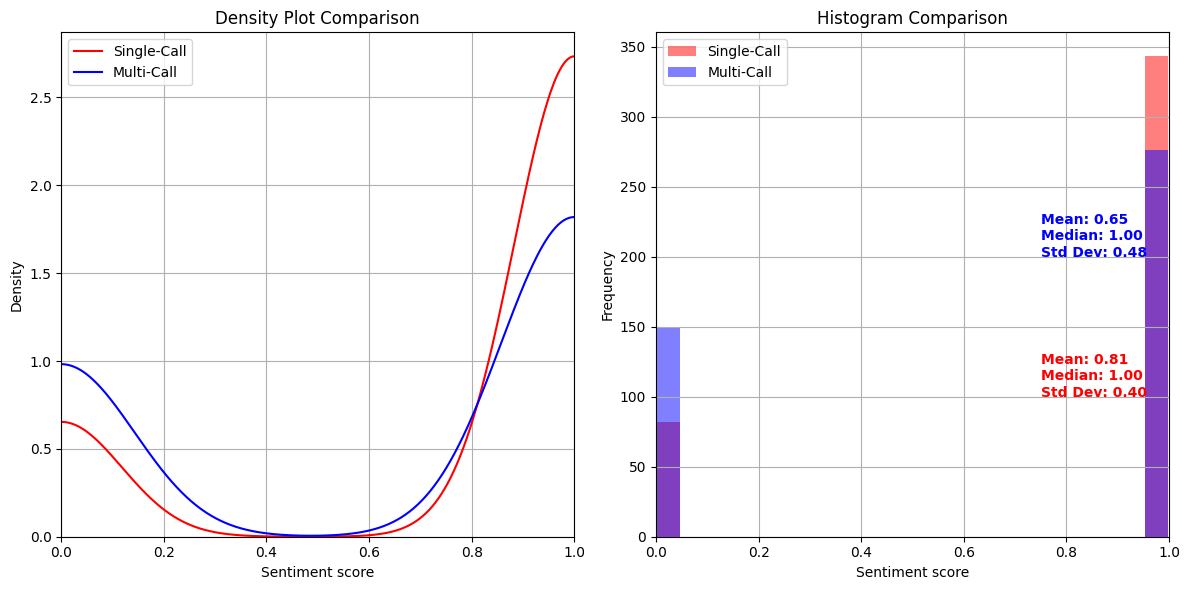

In [74]:
plot_score("sentiment_score", single_call_dataframe, multi_call_dataframe)

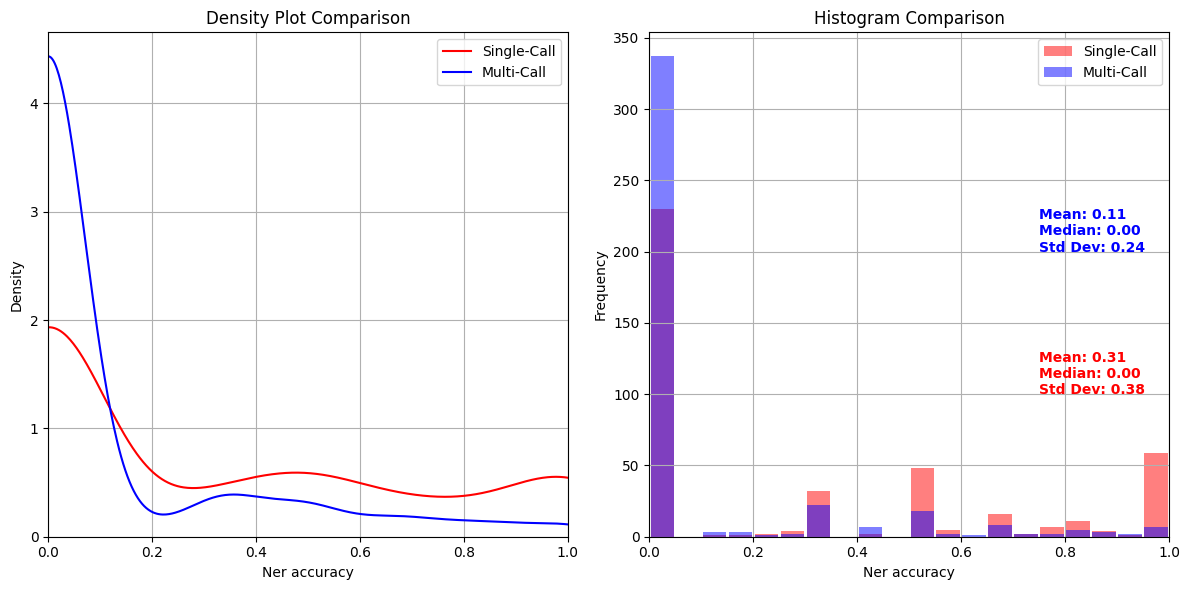

In [75]:
plot_score("ner_accuracy", single_call_dataframe, multi_call_dataframe)

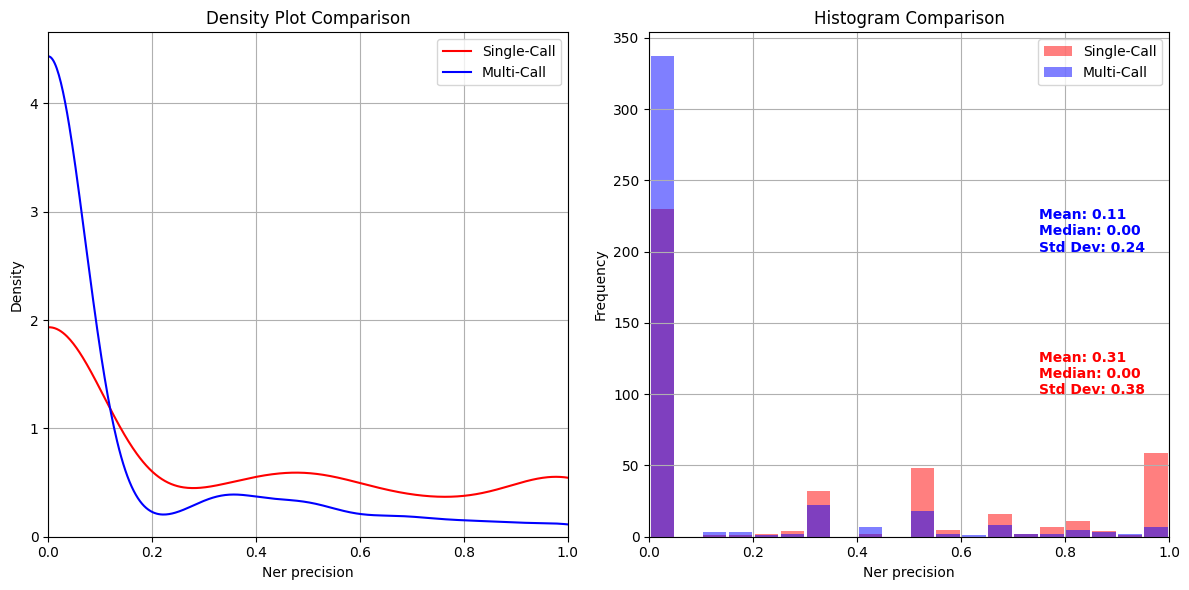

In [76]:
plot_score("ner_precision", single_call_dataframe, multi_call_dataframe)

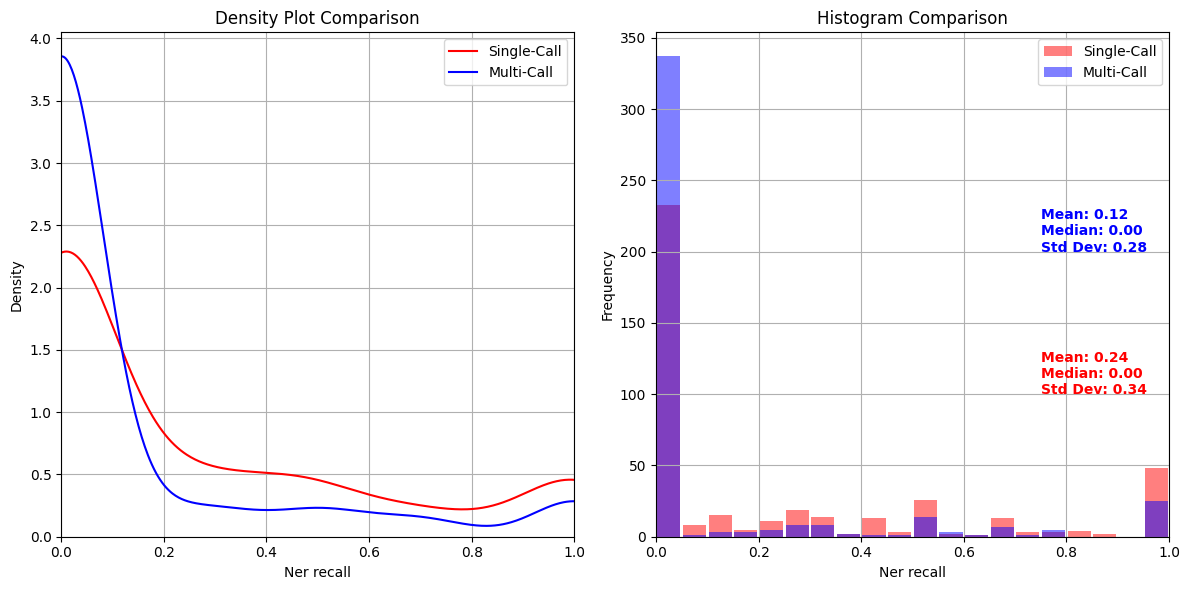

In [77]:
plot_score("ner_recall", single_call_dataframe, multi_call_dataframe)

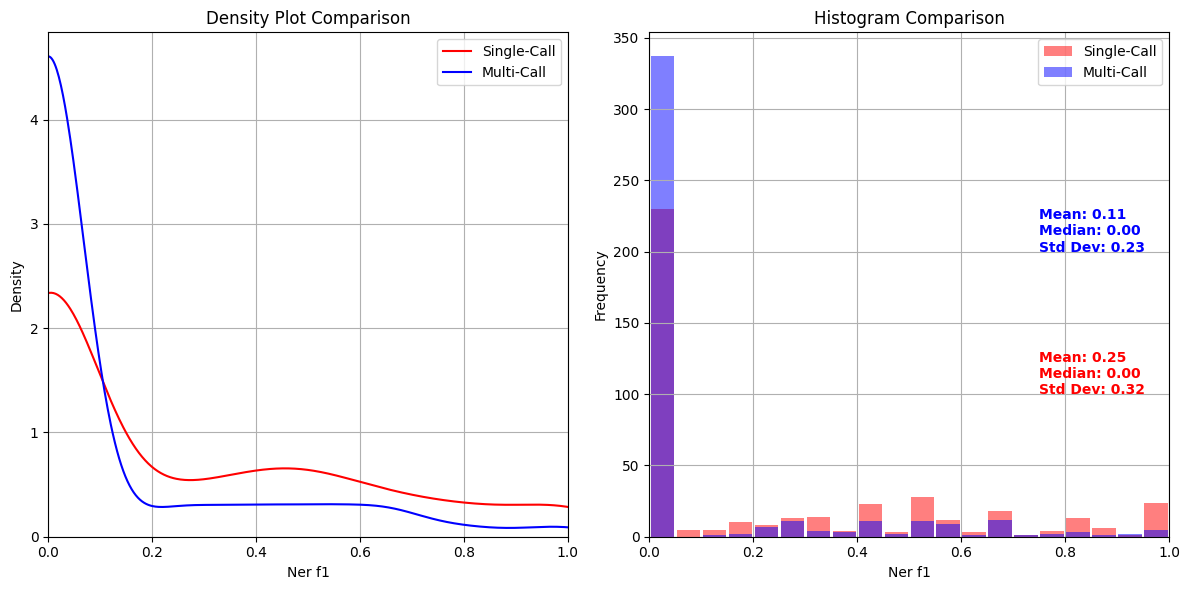

In [78]:
plot_score("ner_f1", single_call_dataframe, multi_call_dataframe)